<a href="https://colab.research.google.com/github/vpxop111/scamrASKSHAK/blob/master/sgmailrakshak.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=db13ca497a8203aeec26dce78100e4ceb65b97801bd1d17c7fa10d09a97ab77f
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/20], Loss: 0.4497, Val Loss: 0.3471
Epoch [2/20], Loss: 0.2883, Val Loss: 0.3300
Epoch [3/20], Loss: 0.2520, Val Loss: 0.3270
Epoch [4/20], Loss: 0.2386, Val Loss: 0.3187
Epoch [5/20], Loss: 0.2197, Val Loss: 0.3092
Epoch [6/20], Loss: 0.2024, Val Loss: 0.3376
Epoch [7/20], Loss: 0.1949, Val Loss: 0.3011
Epoch [8/20], Loss: 0.1689, Val Loss: 0.3088
Epoch [9/20], Loss: 0.1598, Val Loss: 0.3186
Epoch [10/20], Loss: 0.1562, Val Loss: 0.2780
Epoch [11/20], Loss: 0.1479, Val Loss: 0.2734
Epoch [12/20], Loss: 0.1450, Val Loss: 0.2965
Epoch [13/20], Loss: 0.1375, Val Loss: 0.2459
Epoch [14/20], Loss: 0.1270, Val Loss: 0.2594
Epoch [15/20], Loss: 0.1157, Val Loss: 0.2581
Epoch [16/20], Loss: 0.1132, Val Loss: 0.2506
Early stopping triggered


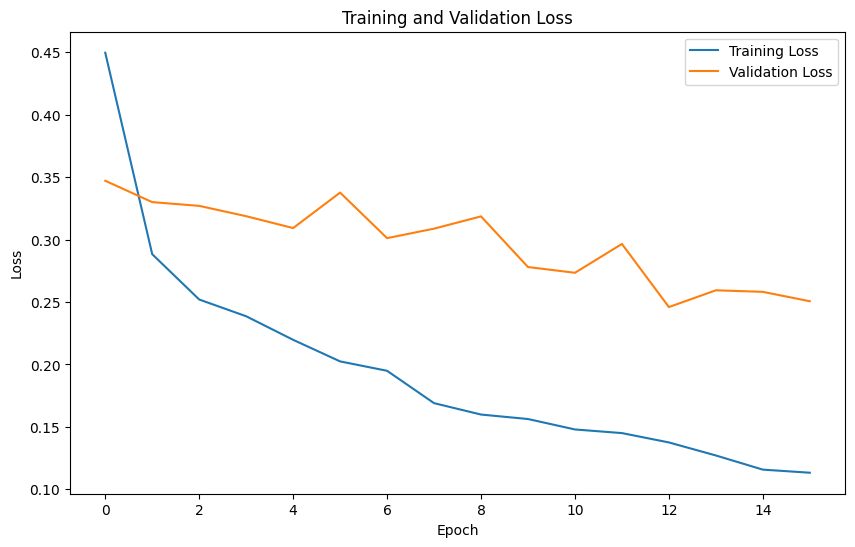

Accuracy: 0.9106
Email Body:
प्रिय उपयोगकर्ता, हमें आपके खाते पर असामान्य गतिविधि का पता चला है। कृपया अपनी पहचान सत्यापित करने और अपने खाते को तुरंत सुरक्षित करने के लिए नीचे दिए गए लिंक पर क्लिक करें: http://secur1ty-gmai1.com

Predicted result: Scam

Email Body:
सभी को नमस्कार, कल सुबह 10 बजे सम्मेलन कक्ष में हमारी टीम की बैठक के बारे में एक त्वरित अनुस्मारक। कृपया अपने प्रोजेक्ट अपडेट लाएं। धन्यवाद!

Predicted result: Ham



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle
from google.colab import drive
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/SGMAILSscsv.csv', encoding='utf-8')

# Preprocess text data
data['Body'].fillna('', inplace=True)
data['Body'] = data['Body'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess label data
y = data['v1'].apply(lambda x: 1 if x == 'Scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data['Body'], y, test_size=0.1, random_state=42)

# Use HashingVectorizer for efficiency with large datasets
vectorizer = HashingVectorizer(n_features=10000)

# Custom Dataset
class EmailDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer
        self.vectorized_texts = self.vectorizer.transform(self.texts).toarray()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        vectorized = self.vectorized_texts[idx]
        label = self.labels.iloc[idx]
        return torch.tensor(vectorized, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Create DataLoaders
train_dataset = EmailDataset(X_train, y_train, vectorizer)
test_dataset = EmailDataset(X_test, y_test, vectorizer)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

# Define the RNN model
class EmailRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.3):
        super(EmailRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x.unsqueeze(1), h0)
        out = self.dropout(out[:, -1, :])
        out = torch.sigmoid(self.fc(out))
        return out

input_size = 10000  # Same as n_features in HashingVectorizer
hidden_size = 64
num_layers = 2
model = EmailRNN(input_size, hidden_size, num_layers).to(device)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Early stopping parameters
patience = 3
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 20
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_gmail_scam_detection_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')

# Save the vectorizer to Google Drive
vectorizer_save_path = '/content/drive/MyDrive/gmail_hash_vectorizer.pkl'
with open(vectorizer_save_path, 'wb') as f:
    pickle.dump(vectorizer, f)

# Prediction functions
def preprocess_email(body, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {body}"
    body_vectorized = vectorizer.transform([system_message])
    body_tensor = torch.tensor(body_vectorized.toarray(), dtype=torch.float32)
    return body_tensor

def predict_email(model, body_tensor):
    model.eval()
    with torch.no_grad():
        output = model(body_tensor.to(device))
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'Scam' if prediction == 1 else 'Ham'

def check_emails(model, bodies, vectorizer):
    results = []
    model.eval()
    with torch.no_grad():
        for body in bodies:
            body_tensor = preprocess_email(body, vectorizer)
            prediction = predict_email(model, body_tensor)
            result = interpret_prediction(prediction)
            results.append((body, result))
    return results

# Example new emails for testing
new_bodies = [
    "प्रिय उपयोगकर्ता, हमें आपके खाते पर असामान्य गतिविधि का पता चला है। कृपया अपनी पहचान सत्यापित करने और अपने खाते को तुरंत सुरक्षित करने के लिए नीचे दिए गए लिंक पर क्लिक करें: http://secur1ty-gmai1.com",
    "सभी को नमस्कार, कल सुबह 10 बजे सम्मेलन कक्ष में हमारी टीम की बैठक के बारे में एक त्वरित अनुस्मारक। कृपया अपने प्रोजेक्ट अपडेट लाएं। धन्यवाद!"
]

results = check_emails(model, new_bodies, vectorizer)

# Print the results
for body, result in results:
    print(f'Email Body:\n{body}\n\nPredicted result: {result}\n')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch [1/20], Loss: 0.6667, Val Loss: 0.5073
Epoch [2/20], Loss: 0.5887, Val Loss: 0.4976
Epoch [3/20], Loss: 0.5427, Val Loss: 0.6783
Epoch [4/20], Loss: 0.6049, Val Loss: 0.5322
Epoch [5/20], Loss: 0.4116, Val Loss: 0.5804
Early stopping triggered


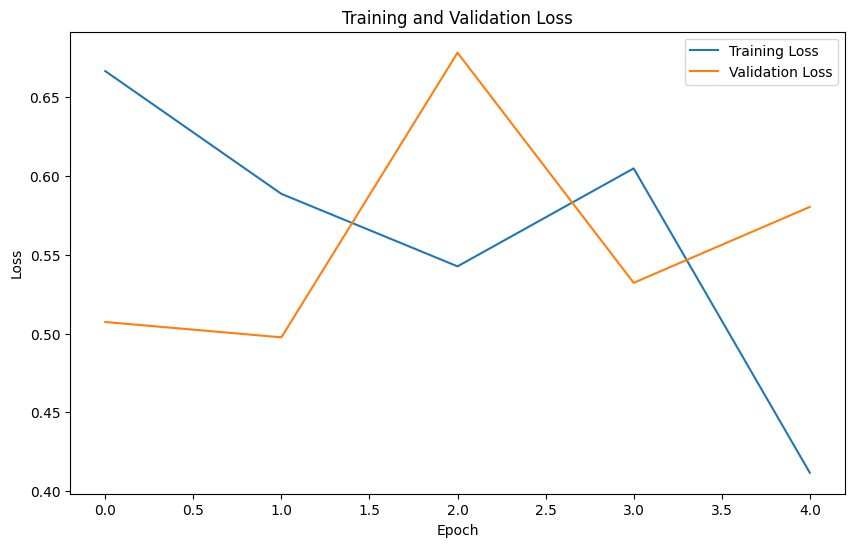

Accuracy: 0.8000
Email Body:
India Post:Your package has arrived at the warehouse and we attempted delivery twice but were unable to ue to incomplete address information. Please update your address details within 48 hours, otherwise your package will be returned. Please update the address in the link: https://indiapostfy.vip/IN After the update is completed we will re-deliver within 24 hours, India Post!

Predicted result: ham



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import HashingVectorizer
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import pickle
from google.colab import drive
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Mount Google Drive
drive.mount('/content/drive')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load dataset
data = pd.read_csv('/content/drive/MyDrive/scam3.csv', encoding='utf-8')

# Preprocess text data
data['v2'].fillna('', inplace=True)
data['v2'] = data['v2'].apply(lambda x: f"System: This message needs to be classified as scam or ham. Message: {x}")

# Preprocess label data
y = data['v1'].apply(lambda x: 1 if x == 'scam' else 0)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(data['v2'], y, test_size=0.1, random_state=42)

# Use HashingVectorizer for efficiency with large datasets
vectorizer = HashingVectorizer(n_features=10000)

# Custom Dataset
class EmailDataset(Dataset):
    def __init__(self, texts, labels, vectorizer):
        self.texts = texts
        self.labels = labels
        self.vectorizer = vectorizer
        self.vectorized_texts = self.vectorizer.transform(self.texts).toarray()

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        vectorized = self.vectorized_texts[idx]
        label = self.labels.iloc[idx]
        return torch.tensor(vectorized, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# Create DataLoaders
train_dataset = EmailDataset(X_train, y_train, vectorizer)
test_dataset = EmailDataset(X_test, y_test, vectorizer)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=4, pin_memory=True)

# Define the RNN model
class EmailRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=0.3):
        super(EmailRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x.unsqueeze(1), h0)
        out = self.dropout(out[:, -1, :])
        out = torch.sigmoid(self.fc(out))
        return out

input_size = 10000  # Same as n_features in HashingVectorizer
hidden_size = 64
num_layers = 2
model = EmailRNN(input_size, hidden_size, num_layers).to(device)

# Set the criterion and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.05, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)

# Early stopping parameters
patience = 3
best_loss = float('inf')
patience_counter = 0

# Train the model
epochs = 20
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs).squeeze()
            val_loss += criterion(outputs, labels).item()

    avg_val_loss = val_loss / len(test_loader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), '/content/drive/MyDrive/best_gmail_scam_detection_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy: {accuracy:.4f}')

# Save the vectorizer to Google Drive
vectorizer_save_path = '/content/drive/MyDrive/gmail_hash_vectorizer.pkl'
with open(vectorizer_save_path, 'wb') as f:
    pickle.dump(vectorizer, f)

# Prediction functions
def preprocess_email(body, vectorizer):
    system_message = f"System: This message needs to be classified as scam or ham. Message: {body}"
    body_vectorized = vectorizer.transform([system_message])
    body_tensor = torch.tensor(body_vectorized.toarray(), dtype=torch.float32)
    return body_tensor

def predict_email(model, body_tensor):
    model.eval()
    with torch.no_grad():
        output = model(body_tensor.to(device))
        prediction = (output > 0.5).float().item()
    return prediction

def interpret_prediction(prediction):
    return 'scam' if prediction == 1 else 'ham'

def check_emails(model, bodies, vectorizer):
    results = []
    model.eval()
    with torch.no_grad():
        for body in bodies:
            body_tensor = preprocess_email(body, vectorizer)
            prediction = predict_email(model, body_tensor)
            result = interpret_prediction(prediction)
            results.append((body, result))
    return results

# Example new emails for testing
new_bodies = [
    "India Post:Your package has arrived at the warehouse and we attempted delivery twice but were unable to ue to incomplete address information. Please update your address details within 48 hours, otherwise your package will be returned. Please update the address in the link: https://indiapostfy.vip/IN After the update is completed we will re-deliver within 24 hours, India Post!",
]

results = check_emails(model, new_bodies, vectorizer)

# Print the results
for body, result in results:
    print(f'Email Body:\n{body}\n\nPredicted result: {result}\n')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 